# Bitcoin Candlestick Prediction Using GPU-accelerated Machine Learning

CUML initiation

In [128]:
#!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#!python rapidsai-csp-utils/colab/pip-install.py

In [129]:
import cuml
cuml.__version__

'25.06.00'

Importing used packages

In [6]:
import numpy as np
import pandas as pd
import time as time
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

Writing a universal GridSearch function

In [131]:
def best_params(model, params, X, y, scoring="f1"):
    grid_model = GridSearchCV(model, param_grid=params, cv=4, verbose=3, scoring="f1")
    grid_model.fit(X, y)
    print("Best Parameters: ",grid_model.best_params_)
    return grid_model.best_estimator_, grid_model.best_params_

Writing a universal split, train and test function

In [132]:
def train_test_report(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    train_time = t1-t0

    t0 = time.time()
    y_pred_test = model.predict(X_test)
    t1 = time.time()
    test_time = t1-t0

    y_pred_train = model.predict(X_train)
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)

    rmse = root_mean_squared_error(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Root Mean Squared Error:", rmse)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Train Score", train_score)
    print("Test Score", test_score)
    print("Training time:", train_time, "seconds")
    print("Test time:", test_time, "seconds")

In [133]:
def multi_scaler(df, *args):
  scl = StandardScaler()
  df[list(args)] = scl.fit_transform(df[list(args)])

Data extraction

In [3]:
btc = yf.download("BTC-USD", "2010-01-01", "2025-01-01")
btc.info()
btc.head(8)

/tmp/ipython-input-4099701076.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", "2010-01-01", "2025-01-01")
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3759 entries, 2014-09-17 to 2024-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3759 non-null   float64
 1   (High, BTC-USD)    3759 non-null   float64
 2   (Low, BTC-USD)     3759 non-null   float64
 3   (Open, BTC-USD)    3759 non-null   float64
 4   (Volume, BTC-USD)  3759 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.2 KB


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24,423.204987,436.112000,421.131989,435.751007,30627700


Downcasting the datatypes and memory usage reduction

In [4]:
btc["Close", "BTC-USD"] = btc["Close", "BTC-USD"].astype(np.float32)
btc["Open", "BTC-USD"] = btc["Open", "BTC-USD"].astype(np.float32)
btc["High", "BTC-USD"] = btc["High", "BTC-USD"].astype(np.float32)
btc["Low", "BTC-USD"] = btc["Low", "BTC-USD"].astype(np.float32)
btc["Volume", "BTC-USD"] = btc["Volume", "BTC-USD"].astype(np.uint32)
btc.info()
btc.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3759 entries, 2014-09-17 to 2024-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3759 non-null   float32
 1   (High, BTC-USD)    3759 non-null   float32
 2   (Low, BTC-USD)     3759 non-null   float32
 3   (Open, BTC-USD)    3759 non-null   float32
 4   (Volume, BTC-USD)  3759 non-null   uint32 
dtypes: float32(4), uint32(1)
memory usage: 102.8 KB


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


Breif statistical overview of our data

In [136]:
btc.describe()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
count,3759.000000,3759.000000,3759.000000,3759.000000,3.759000e+03
mean,19585.857422,20003.126953,19103.287109,19562.392578,1.574499e+09
std,22126.521484,22584.210938,21597.380859,22097.876953,1.387654e+09
min,178.102997,211.731003,171.509995,176.897003,8.027040e+05
25%,1226.309998,1242.800049,1208.440002,1223.955017,1.444080e+08
50%,9350.529297,9530.518555,9202.353516,9349.161133,1.288020e+09
75%,30569.386719,31350.405273,30050.850586,30526.150391,2.746206e+09
max,106140.601562,108268.445312,105291.734375,106147.296875,4.292415e+09


Close price line plot

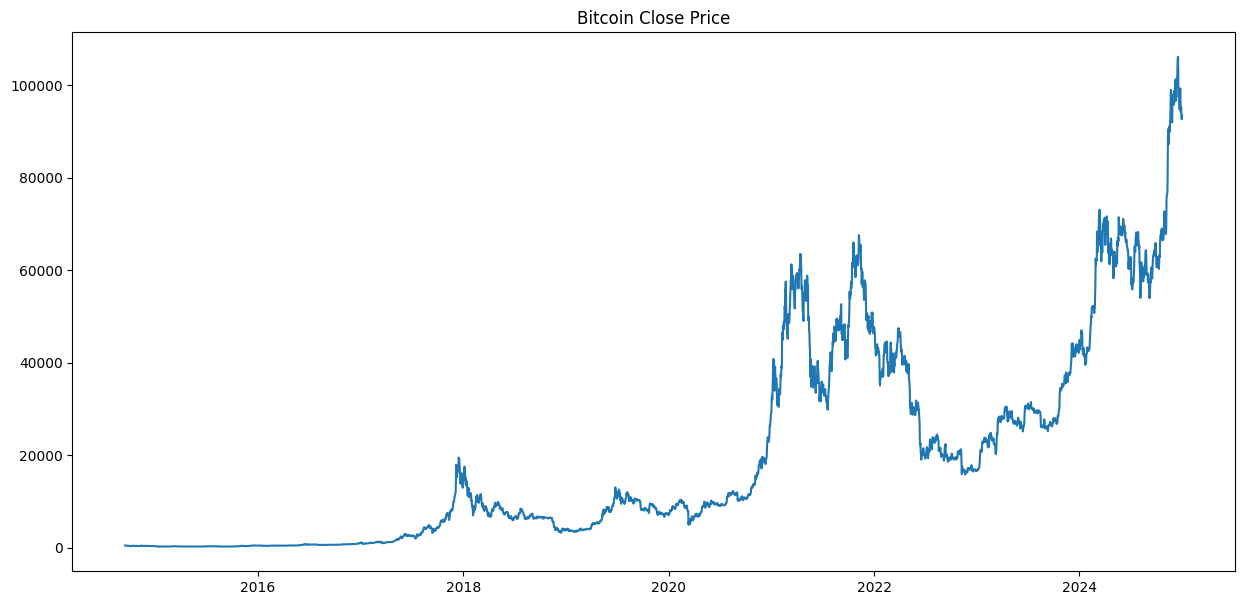

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(btc.index, btc["Close"])
plt.title('Bitcoin Close Price')
plt.show()

Creating a column for tommorow's close price

In [137]:
btc["T-close"] = btc["Close"].shift(-1)
btc= btc.drop("2024-12-31")
print(btc)

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2014-09-17    457.334015    468.174011    452.421997    465.864014   
2014-09-18    424.440002    456.859985    413.104004    456.859985   
2014-09-19    394.795990    427.834991    384.532013    424.102997   
2014-09-20    408.903992    423.295990    389.882996    394.673004   
2014-09-21    398.821014    412.425995    393.181000    408.084991   
...                  ...           ...           ...           ...   
2024-12-26  95795.515625  99884.570312  95137.882812  99297.695312   
2024-12-27  94164.859375  97294.843750  93310.742188  95704.976562   
2024-12-28  95163.929688  95525.898438  94014.289062  94160.187500   
2024-12-29  93530.226562  95174.875000  92881.789062  95174.054688   
2024-12-30  92643.210938  94903.320312  91317.132812  93527.195312   

Price           Vol

In [138]:
btc.columns = btc.columns.get_level_values(0)
print(btc.columns)
display(btc.head())

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'T-close'], dtype='object', name='Price')


Price,Close,High,Low,Open,Volume,T-close
Date,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,424.440002
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,394.795990
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,408.903992
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,398.821014
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,402.152008


Creating a column for the direction of tomorrow's close price

In [139]:
btc["Direction"] = btc["T-close"] - btc["Close"]
btc.head()

Price,Close,High,Low,Open,Volume,T-close,Direction
Date,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,424.440002,-32.894012
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,394.795990,-29.644012
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,408.903992,14.108002
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,398.821014,-10.082977
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,402.152008,3.330994


In [140]:
btc['Direction'] = np.where(btc['Direction'] > 0, 1, 0)
display(btc.head())

Price,Close,High,Low,Open,Volume,T-close,Direction
Date,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,424.440002,0
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,394.795990,0
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,408.903992,1
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,398.821014,0
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,402.152008,1


Scaling the data

In [141]:
multi_scaler(btc, "Close", "High", "Low", "Open", "Volume", "T-close")
btc.head()

Price,Close,High,Low,Open,Volume,T-close,Direction
Date,,,,,,,
2014-09-17,-0.864901,-0.865394,-0.863981,-0.864559,-1.119709,-0.866309,0
2014-09-18,-0.866390,-0.865896,-0.865805,-0.864967,-1.110033,-0.867649,0
2014-09-19,-0.867732,-0.867183,-0.867130,-0.866451,-1.107556,-0.867012,1
2014-09-20,-0.867093,-0.867384,-0.866881,-0.867785,-1.108317,-0.867467,0
2014-09-21,-0.867550,-0.867866,-0.866729,-0.867177,-1.115728,-0.867317,1


Seperating the X and y (Label) for the machine learning proccess

In [142]:
print(btc.columns)
X = btc.drop("Direction", axis=1)
y = btc["Direction"]
print(X.head(), y.head())

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'T-close', 'Direction'], dtype='object', name='Price')
Price          Close      High       Low      Open    Volume   T-close
Date                                                                  
2014-09-17 -0.864901 -0.865394 -0.863981 -0.864559 -1.119709 -0.866309
2014-09-18 -0.866390 -0.865896 -0.865805 -0.864967 -1.110033 -0.867649
2014-09-19 -0.867732 -0.867183 -0.867130 -0.866451 -1.107556 -0.867012
2014-09-20 -0.867093 -0.867384 -0.866881 -0.867785 -1.108317 -0.867467
2014-09-21 -0.867550 -0.867866 -0.866729 -0.867177 -1.115728 -0.867317 Date
2014-09-17    0
2014-09-18    0
2014-09-19    1
2014-09-20    0
2014-09-21    1
Name: Direction, dtype: int64


Best parameters and performance of Logistic Regression

In [147]:
reg_model = LogisticRegression()
reg_params = {"max_iter":[200, 500, 1000, 2000, 5000], "penalty":["l1", "l2"]}
best_reg, best_reg_params = best_params(reg_model, reg_params, X, y, scoring="accuracy")

reg = LogisticRegression(**best_reg_params)
train_test_report(reg, X,y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[2025-08-22 15:54:11.994] [CUML] [warning] QWL-QN: max iterations reached
[2025-08-22 15:54:11.994] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[CV 1/4] END ..........max_iter=200, penalty=l1;, score=0.693 total time=   0.2s
[2025-08-22 15:54:12.167] [CUML] [warning] QWL-QN: max iterations reached
[2025-08-22 15:54:12.168] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[CV 2/4] END ..........max_iter=200, penalty=l1;, score=0.779 total time=   0.2s
[2025-08-22 15:54:12.311] [CUML] [warning] QWL-QN: max iterations reached
[2025-08-22 15:54:12.311] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model

Best parameters and performance of Kneighbors Classifier

In [148]:
knn_model = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1,20), "metric": ["euclidean", "cosine", "manhattan"]}
best_knn, best_knn_params = best_params(knn_model, knn_params, X, y, scoring="accuracy")

knn = KNeighborsClassifier(**best_knn_params)
train_test_report(knn, X,y)

[2025-08-22 15:54:42.498] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 4 folds for each of 57 candidates, totalling 228 fits
[2025-08-22 15:54:42.508] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV 1/4] END ...metric=euclidean, n_neighbors=1;, score=0.694 total time=   0.0s
[2025-08-22 15:54:42.524] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV 2/4] END ...metric=euclidean, n_neighbors=1;, score=0.427 total time=   0.0s
[2025-08-22 15:54:42.539] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV 3/4] END ...metric=euclidean, n_neighbors=1;, score=0.555 total time=   0.0s
[2025-08-22 15:54:42.554] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV 4/4] END ...metric=euclidean, n_neighbors=1;, score=0.451 total time=   0.0s
[2025-08-22 15:54:42.572] [CUML] [info] Unused keyword parameter

Best parameters and performance of Support Vector Classifier

In [149]:
svc_model = SVC()
svc_params = {"C": list(np.arange(0,11)), "gamma": ["auto", "scale"] , "kernel": ["linear", "poly", "rbf", "sigmoid"], "degree": list(np.arange(1,5)), "max_iter": [100, 200, 300]}
best_svc, best_svc_params = best_params(svc_model, svc_params, X, y, scoring="accuracy")

svc = SVC(**best_svc_params)
train_test_report(svc, X,y)

Fitting 4 folds for each of 1056 candidates, totalling 4224 fits
[CV 1/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=100;, score=0.692 total time=   0.0s
[CV 2/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=100;, score=0.692 total time=   0.0s
[CV 3/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=100;, score=0.691 total time=   0.0s
[CV 4/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=100;, score=0.692 total time=   0.0s
[CV 1/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=200;, score=0.692 total time=   0.0s
[CV 2/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=200;, score=0.692 total time=   0.0s
[CV 3/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=200;, score=0.691 total time=   0.0s
[CV 4/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=200;, score=0.692 total time=   0.0s
[CV 1/4] END C=0, degree=1, gamma=auto, kernel=linear, max_iter=300;, score=0.692 total time=   0.0s
[CV 2/4] END C=0, degree=1